In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# 设置中文显示
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['axes.unicode_minus'] = False

### 定义亚洲数据处理类


In [33]:
class ASIData:
    def __init__(self,file_data,file_dictionary):
        self.file_data = file_data
        self.flie_dictionary = file_dictionary

    def get_data(self):
        data = pd.read_excel(self.file_data)
        common_dic = pd.read_csv(self.flie_dictionary)
        return data,common_dic
    def dataFILTER(self):
        data,common_dic=self.get_data()
        dates=data['Last Update']
        # 2. 找到日期中最近的一天
        latest_date = pd.to_datetime(dates).max()

        # 3. 计算最近日期距离2000年1月1日的天数
        days_since_2000 = (latest_date - pd.to_datetime('2000-01-01')).days

        print("最近观测日期:", latest_date)
        print("距离2000年1月1日的天数:", days_since_2000)


        data=data[['Disaster Type','Disaster Subtype','Country',
                   'Location','Start Year','End Year'#,'Start Month',
                   ,'Total Damage, Adjusted']]
        # data=data.dropna()
        # data['Start Month']=data['Start Month'].astype(int)
        data.sort_values(['Start Year','Country','Location',#'Start Month',
                          'Disaster Subtype']).reset_index(drop=True)
      
        # 提取省份

        data['province'] = data['Location'].str.extract(r',\s*(\w+(?:\s+\w+)*)\s*province')

        # grouped = df.groupby(["Year", "Country", "Province", "Disaster Subtype"])
        # count_df = grouped.size().reset_index(name="Disaster Subtype Count")
        grouped = data.groupby(['Start Year', 'Country', 'province',#'Start Month',
                                'Disaster Subtype'])
        counts = grouped.size().reset_index(name='COUNT')
        counts['Disaster Subtype'] = counts['Disaster Subtype'].str.lower()
        common_event_types = common_dic['EVENT_TYPE'].unique()

        # 使用isin函数筛选data DataFrame中的行
        filtered_data = counts[counts['Disaster Subtype'].isin(common_event_types)]
        return filtered_data,latest_date,days_since_2000
    def upload_data(self,filename="filered_data"):
        data,common_dic=self.get_data()
        data,latest_date,days_since_2000=self.dataFILTER()
        data.to_csv('{}.csv'.format('dataset_process/'+filename),index=False)
    def statistics(self,filename="rate"):
        data,common_dic=self.get_data()
        data,latest_date,days_since_2000=self.dataFILTER()
        grouped = data.groupby(["Country", "province", "Disaster Subtype"])["COUNT"].sum()
        
        # 2. 将每个组的"COUNT"总和除以days_since_2000
        rate = grouped / days_since_2000
        grouped = grouped.reset_index()
        # 3. 将结果保存到名为"rate"的变量中
        rate = rate.reset_index()  # 将索引重置为列
        rate.columns = ["Country", "province", "Disaster Subtype", "rate"]  # 重命名列78/9dfv7
        rate.to_csv('{}.csv'.format("dataset_process/"+filename),index=False)
        return rate,grouped

    

### 以美国为主要数据集


In [34]:
# 加载数据
def loadDataSet(fileName):
    data = pd.read_csv(fileName)
    return data
url_2023=r"D:\VSCodeWorkSpace\2024_C\data\StormEvents_details-ftp_v1.0_d2023_c20240117.csv"
url_2022=r"D:\VSCodeWorkSpace\2024_C\data\StormEvents_details-ftp_v1.0_d2022_c20231217.csv"
url_2021=r"D:\VSCodeWorkSpace\2024_C\data\StormEvents_details-ftp_v1.0_d2021_c20231217.csv"
dic=r"D:\VSCodeWorkSpace\2024_C\dataprocess\dataset_process\dic_incommon.csv"
USA_data_2023=loadDataSet(url_2023)
USA_data_2022=loadDataSet(url_2022)
USA_data_2021=loadDataSet(url_2021)

USA_data = pd.concat([USA_data_2021,USA_data_2022, USA_data_2023])
dates=USA_data['BEGIN_DATE_TIME']

USA_data=USA_data[['YEAR','BEGIN_DATE_TIME','EVENT_TYPE','STATE']]
USA_data['EVENT_TYPE']=USA_data['EVENT_TYPE'].str.lower()
# 按STATE升序,EVENT_TYPE升序排序
df_sorted = USA_data.sort_values(['STATE','EVENT_TYPE']).reset_index(drop=True)

common_dic=loadDataSet(dic)
event_types = common_dic['EVENT_TYPE']
mask = USA_data['EVENT_TYPE'].isin(event_types)
filtered_data = USA_data[mask].reset_index(drop=True)
filtered_data

# 按月统计EVENT发生次数

filtered_data['Month'] = pd.to_datetime(filtered_data['BEGIN_DATE_TIME'], format="%d-%b-%y %H:%M:%S").dt.month
grouped_data = filtered_data.groupby(['YEAR', 'Month', 'STATE', 'EVENT_TYPE']).size().reset_index(name='Count')
grouped_data



,YEAR,Month,STATE,EVENT_TYPE,Count
0,2021,1,ALABAMA,hail,1
1,2021,1,ALABAMA,tornado,1
2,2021,1,ARIZONA,drought,14
3,2021,1,ARIZONA,hail,1
4,2021,1,CALIFORNIA,coastal flood,7
...,...,...,...,...,...
3083,2023,10,VIRGINIA,coastal flood,2
3084,2023,10,VIRGINIA,drought,3
3085,2023,10,WASHINGTON,tornado,1
3086,2023,10,WISCONSIN,drought,25


In [35]:
# 事件强度字典
event_intensity_dict = {
    'tsunami':10,
    'riverine flood':7,
    'volcanic activity (general)':7,
    'lava flow':5,
    'storm (general)':5,
    'cold wave':2,
    "land fire (brush, bush, pasture)":5,
    'ash fall':3,
    'lightning/thunderstorms':5,
    'hail':3,
    'drought':3,
    'blizzard/winter storm':2,
    'heat wave':2,
    'coastal flood':2,
    'rockfall (wet)':5,
    'flood (general)':6,
    'extra-tropical storm':10,
    'severe weather':5,
    'ground movement':7,
    'mudslide':6,
    'tropical cyclone':7,
    'pyroclastic flow':2,
    'derecho':5,
    'landslide (dry)':4,
    'severe winter conditions':5,
    'tornado':7,
    'flash flood':4,
    'forest fire':4,
    'storm surge':5,
    'wildfire(general)':4,
    'sand/dust storm':3,
    'landslide (wet)':3
}


In [36]:
# 按统计2021-2023各州发生各EVENT的rate

#统计观测时间长度
latest_date = pd.to_datetime(dates,format="%d-%b-%y %H:%M:%S").max()
early_date=pd.to_datetime(dates,format="%d-%b-%y %H:%M:%S").min()


days_since_2000 = (latest_date - early_date).days

print("最近观测日期:", latest_date)
print("最远观测日期：",early_date)
print("观测时间长度为:", days_since_2000)

# 计算观测时间内发生事件次数
# 2. 将每个组的"COUNT"总和除以days_since_2000
grouped = grouped_data.groupby(['STATE', 'EVENT_TYPE'])["Count"].sum()
rate = grouped / days_since_2000
grouped = grouped.reset_index()
# 3. 将结果保存到名为"rate"的变量中
rate = rate.reset_index()  # 将索引重置为列
rate.columns = ['STATE', 'EVENT_TYPE', "rate"]  # 重命名列
rate.to_csv("dataset_process/rate_USA.csv")
rate


最近观测日期: 2023-10-31 16:39:00
最远观测日期： 2021-01-01 00:00:00
观测时间长度为: 1033


,STATE,EVENT_TYPE,rate
0,ALABAMA,drought,0.037754
1,ALABAMA,flash flood,0.353340
2,ALABAMA,hail,0.455954
3,ALABAMA,tornado,0.290416
4,ALASKA,coastal flood,0.014521
...,...,...,...
218,WISCONSIN,tornado,0.096805
219,WYOMING,drought,0.001936
220,WYOMING,flash flood,0.043562
221,WYOMING,hail,0.419167


In [48]:
#映射到EVENT_TYPE中
rate['EVENT_INTENSITY'] = rate['EVENT_TYPE'].map(event_intensity_dict)
rate

,STATE,EVENT_TYPE,rate,EVENT_INTENSITY
0,ALABAMA,drought,0.037754,3
1,ALABAMA,flash flood,0.353340,4
2,ALABAMA,hail,0.455954,3
3,ALABAMA,tornado,0.290416,7
4,ALASKA,coastal flood,0.014521,2
...,...,...,...,...
218,WISCONSIN,tornado,0.096805,7
219,WYOMING,drought,0.001936,3
220,WYOMING,flash flood,0.043562,4
221,WYOMING,hail,0.419167,3


In [51]:
# 先将rate列乘以EVENT_INTENSITY每行的对应元素,将各行乘积按STATE求和
rate['danger_factor'] = rate['rate'] * rate['EVENT_INTENSITY']
print(rate)
danger_factor = rate.groupby(['STATE'])['danger_factor'].sum().reset_index()
danger_factor.to_csv("dataset_process/danger_factor_USA.csv",index=False)
danger_factor


         STATE     EVENT_TYPE      rate  EVENT_INTENSITY  danger_factor
0      ALABAMA        drought  0.037754                3       0.113262
1      ALABAMA    flash flood  0.353340                4       1.413359
2      ALABAMA           hail  0.455954                3       1.367861
3      ALABAMA        tornado  0.290416                7       2.032914
4       ALASKA  coastal flood  0.014521                2       0.029042
..         ...            ...       ...              ...            ...
218  WISCONSIN        tornado  0.096805                7       0.677638
219    WYOMING        drought  0.001936                3       0.005808
220    WYOMING    flash flood  0.043562                4       0.174250
221    WYOMING           hail  0.419167                3       1.257502
222    WYOMING        tornado  0.024201                7       0.169409

[223 rows x 5 columns]


,STATE,danger_factor
0,ALABAMA,4.927396
1,ALASKA,0.036786
2,AMERICAN SAMOA,0.062924
3,ARIZONA,4.495644
4,ARKANSAS,4.541142
5,CALIFORNIA,5.031946
6,COLORADO,6.575992
7,CONNECTICUT,0.797677
8,DELAWARE,0.214908
9,DISTRICT OF COLUMBIA,0.098742


In [52]:
# 创建州名称映射字典
state_mapping = {
    'ALABAMA': 'AL',
    'ALASKA': 'AK',
    'ARIZONA': 'AZ',
    'ARKANSAS': 'AR',
    'CALIFORNIA': 'CA',
    'COLORADO': 'CO',
    'CONNECTICUT': 'CT',
    'DELAWARE': 'DE',
    'FLORIDA': 'FL',
    'GEORGIA': 'GA',
    'HAWAII': 'HI',
    'IDAHO': 'ID',
    'ILLINOIS': 'IL',
    'INDIANA': 'IN',
    'IOWA': 'IA',
    'KANSAS': 'KS',
    'KENTUCKY': 'KY',
    'LOUISIANA': 'LA',
    'MAINE': 'ME',
    'MARYLAND': 'MD',
    'MASSACHUSETTS': 'MA',
    'MICHIGAN': 'MI',
    'MINNESOTA': 'MN',
    'MISSISSIPPI': 'MS',
    'MISSOURI': 'MO',
    'MONTANA': 'MT',
    'NEBRASKA': 'NE',
    'NEVADA': 'NV',
    'NEW HAMPSHIRE': 'NH',
    'NEW JERSEY': 'NJ',
    'NEW MEXICO': 'NM',
    'NEW YORK': 'NY',
    'NORTH CAROLINA': 'NC',
    'NORTH DAKOTA': 'ND',
    'OHIO': 'OH',
    'OKLAHOMA': 'OK',
    'OREGON': 'OR',
    'PENNSYLVANIA': 'PA',
    'RHODE ISLAND': 'RI',
    'SOUTH CAROLINA': 'SC',
    'SOUTH DAKOTA': 'SD',
    'TENNESSEE': 'TN',
    'TEXAS': 'TX',
    'UTAH': 'UT',
    'VERMONT': 'VT',
    'VIRGINIA': 'VA',
    'WASHINGTON': 'WA',
    'WEST VIRGINIA': 'WV',
    'WISCONSIN': 'WI',
    'WYOMING': 'WY'
}

# 替换州名称为缩写
# 读取风险指数数据
risk_data = pd.read_csv(r"D:\VSCodeWorkSpace\2024_C\dataprocess\dataset_process\danger_factor_USA.csv")
risk_data['STATE'] = risk_data['STATE'].replace(state_mapping)

In [118]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go



# 使用plotly.express绘制地图
fig = px.choropleth(risk_data, locations='STATE',
                    locationmode='USA-states', color='danger_factor',
                    scope='usa', 
                    color_continuous_scale='Hot',
                    color_continuous_midpoint=15,  # 设置颜色划分的中点值
                    range_color=(1,1),  # 设置颜色划分的步长
                    labels={'danger_factor': 'Risk Index'})


# 设置图表布局
fig.update_layout(title_text='U.S. State Risk Index', title_font_size=20)
# Get the states with higher danger_factor values
threshold=10
high_risk_states = risk_data[risk_data['danger_factor'] > threshold]
print(high_risk_states)
fig.show()




   STATE  danger_factor
38    OK      10.830591
46    TX      26.904163


### 以LOUISIANA州三年来的flash flood次数为例，绘制发生次数随时间的变化趋势，单位为月

C:\Users\JiangJinrui\AppData\Local\Temp\ipykernel_70236\449423980.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JiangJinrui\AppData\Local\Temp\ipykernel_70236\449423980.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



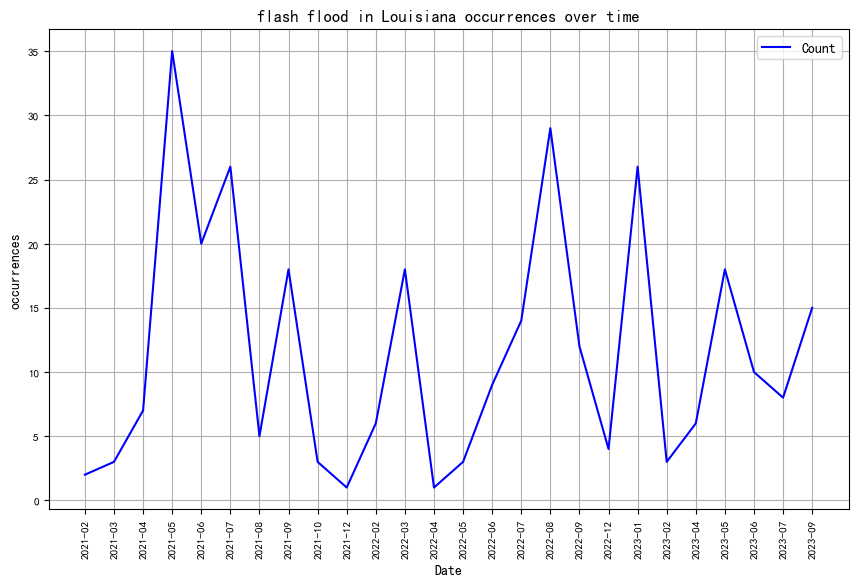

,YEAR,Month,STATE,EVENT_TYPE,Count,danger_factor,DATE
60,2021,2,LOUISIANA,flash flood,2,2.512101,2021-02
116,2021,3,LOUISIANA,flash flood,3,3.258470,2021-03
194,2021,4,LOUISIANA,flash flood,7,0.033882,2021-04
276,2021,5,LOUISIANA,flash flood,35,NaN,2021-05
385,2021,6,LOUISIANA,flash flood,20,NaN,2021-06
519,2021,7,LOUISIANA,flash flood,26,NaN,2021-07
645,2021,8,LOUISIANA,flash flood,5,NaN,2021-08
761,2021,9,LOUISIANA,flash flood,18,NaN,2021-09
861,2021,10,LOUISIANA,flash flood,3,NaN,2021-10
995,2021,12,LOUISIANA,flash flood,1,NaN,2021-12


In [42]:
# 筛选出路易斯安娜州的数据
filtered_data = grouped_data[(grouped_data["STATE"] == "LOUISIANA") 
                                & (grouped_data["EVENT_TYPE"] == "flash flood")]
filtered_data.reset_index(drop=False)

# 将日期转换为标准形式
filtered_data['DATE'] = pd.to_datetime(filtered_data[['YEAR', 'Month']].assign(day=1))
filtered_data['DATE'] = filtered_data['DATE'].dt.strftime("%Y-%m")

# 绘制折线图
plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

plt.plot(filtered_data["DATE"], filtered_data["Count"],linestyle='-', color='blue')
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("occurrences")
plt.title("flash flood in Louisiana occurrences over time")
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)

plt.legend(['Count'])
plt.show()
filtered_data

### 灾害发生随时间变化次数具有周期性，利用ARIMA进行时间序列分析

In [55]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
# filtered_data.set_index('DATE', inplace=True)
# 划分训练集和测试集
train_data = filtered_data.iloc[:-1]
test_data = filtered_data.iloc[-1:]

# 创建时间序列
time_series = pd.Series(train_data['Count'].values, index=pd.to_datetime(train_data.index))

# 创建ARIMA模型
model = sm.tsa.ARIMA(time_series, order=(1, 0, 0))
results = model.fit()

# 预测测试集
prediction = results.predict(start=len(train_data), end=len(train_data)+len(test_data)-1)
# 将预测结果日期设置为测试集日期
prediction.index = test_data.index

# 打印预测结果及对应日期
print("预测结果：")
for date, count in prediction.items():
    print(f"{date}: {count}")

# 计算均方根误差（Root Mean Squared Error，RMSE）
rmse = mean_squared_error(test_data['Count'], prediction, squared=False)
print("均方根误差(RMSE):", rmse)

# 预测2023年10月

prediction = results.predict(start=len(train_data)+len(test_data), end=len(train_data)+len(test_data))

# 打印预测结果及对应日期
print("2023年10月的预测结果:")
for date, count in prediction.items():
    print(f"发生次数: {count}")

预测结果：
2948: 11.276791374785493
均方根误差(RMSE): 3.7232086252145074
2023年10月的预测结果:
发生次数: 11.443400846140262


d:\Python3.9.7\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

d:\Python3.9.7\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

d:\Python3.9.7\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

d:\Python3.9.7\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

d:\Python3.9.7\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method i

### 获取极端天气事件字典

In [54]:


# 加载dictionary和dictionary2文件
df2 = pd.read_csv(r'D:\VSCodeWorkSpace\2024_C\dataVisualise\dictionary_2.csv')
df1 = pd.read_csv(r'D:\VSCodeWorkSpace\2024_C\dataprocess\dictionary.csv')

# 提取两个文件中的事件类型列
df1['事件种类']=df1['事件种类'].str.lower()
df2['事件种类']=df1['事件种类'].str.lower()
events1 = set(df1['事件种类'])
events2 = set(df2['事件种类'])

# 找到两个文件中的公共部分
common_events = events1.intersection(events2)
common_dic = pd.DataFrame(common_events, columns=['EVENT_TYPE'])
common_dic.to_csv('{}.csv'.format('dataset_process/dic_incommon'),index=False)
common_dic

,EVENT_TYPE
0,sand/dust storm
1,drought
2,landslide (wet)
3,coastal flood
4,ash fall
5,landslide (dry)
6,extra-tropical storm
7,lightning/thunderstorms
8,mudslide
9,tropical cyclone


In [ ]:
file_data=r"D:\VSCodeWorkSpace\2024_C\data\public_emdat_custom_request_2024-02-02_7d30c6e3-dd6a-49d6-a677-2ff9ff7a6aee.xlsx"
file_dictionary=r"D:\VSCodeWorkSpace\2024_C\dataprocess\dic_incommon.csv"
asiadata=ASIData(file_data,file_dictionary)
asiadata.get_data()
filtered_data,latest_date,days_since_2000=asiadata.dataFILTER()

asiadata.upload_data(filename="filered_data_AISA")
b=asiadata.statistics(filename="rate_AISA")
b
filtered_data

最近观测日期: 2024-01-23 00:00:00
距离2000年1月1日的天数: 8788
最近观测日期: 2024-01-23 00:00:00
距离2000年1月1日的天数: 8788
最近观测日期: 2024-01-23 00:00:00
距离2000年1月1日的天数: 8788


,Start Year,Country,province,Disaster Subtype,COUNT
0,2000,Afghanistan,Uruzgan,drought,1
1,2000,Armenia,Lori,drought,1
2,2000,Azerbaijan,Yukhari Garabakh,drought,1
3,2000,Bangladesh,Chittagong,coastal flood,1
4,2000,Bangladesh,Chittagong,flash flood,1
...,...,...,...,...,...
1341,2022,Viet Nam,Bac Kan and Cao Bang,flood (general),1
1342,2022,Viet Nam,Kon Tum,storm surge,1
1343,2023,Indonesia,Southeast Sulawesi and Central Sulawesi,severe weather,1
1344,2023,Thailand,Narathiwat,flood (general),1


### 查看美洲的数据集

In [ ]:
file_data=r"D:\VSCodeWorkSpace\2024_C\data\public_emdat_custom_request_2024-02-02_dd97d827-78f7-4070-9c73-86139a6f2f2d.xlsx"
file_dictionary=r"D:\VSCodeWorkSpace\2024_C\dataprocess\dic_incommon.csv"
asiadata=ASIData(file_data,file_dictionary)
asiadata.get_data()
filtered_data_a,latest_date,days_since_2000=asiadata.dataFILTER()
filtered_data_a
asiadata.upload_data("filered_data_AMRICA")
b,grouped=asiadata.statistics(filename="rate_AMRICA")
filtered_data_a

最近观测日期: 2024-01-29 00:00:00
距离2000年1月1日的天数: 8794
最近观测日期: 2024-01-29 00:00:00
距离2000年1月1日的天数: 8794
最近观测日期: 2024-01-29 00:00:00
距离2000年1月1日的天数: 8794


,Start Year,Country,province,Disaster Subtype,COUNT
0,2000,Argentina,Buenos Aires,lightning/thunderstorms,1
1,2000,Argentina,Formosa,forest fire,1
2,2000,Argentina,La Cordoba,flood (general),1
3,2000,Argentina,Santa Cruz,cold wave,1
4,2000,Argentina,Santa Fe,flood (general),2
...,...,...,...,...,...
963,2021,Peru,Satipo,flood (general),1
964,2022,Cuba,and Matanzas,tropical cyclone,1
965,2022,Ecuador,El Oro,flood (general),1
966,2022,Ecuador,Tungurahua,riverine flood,1


### 以Florida每年tropical cyclone为例，绘制发生次数随时间的变化趋势，单位为年

C:\Users\JiangJinrui\AppData\Local\Temp\ipykernel_28360\1231636569.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["Start Year"] = pd.to_datetime(filtered_data["Start Year"], format="%Y")


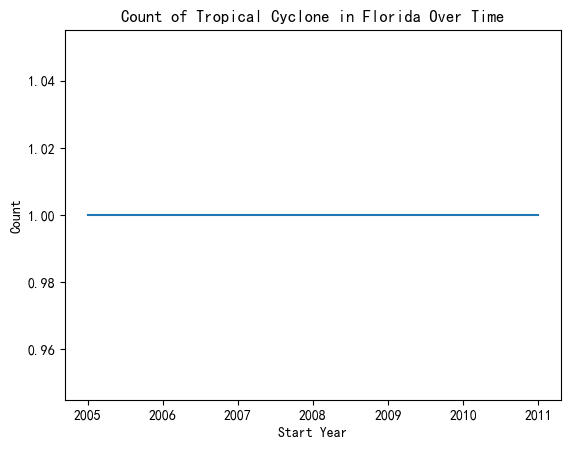

,Start Year,Country,province,Disaster Subtype,COUNT
325,2005-01-01,United States of America,Florida,tropical cyclone,1
500,2008-01-01,United States of America,Florida,tropical cyclone,1
675,2011-01-01,United States of America,Florida,tropical cyclone,1


In [ ]:
# 筛选出满足条件的数据
filtered_data = filtered_data_a[(filtered_data_a["province"] == "Florida") 
                                & (filtered_data_a["Disaster Subtype"] == "tropical cyclone")]
filtered_data
# 将"Year"列转换为日期类型
filtered_data["Start Year"] = pd.to_datetime(filtered_data["Start Year"], format="%Y")



# 绘制折线图
plt.plot(filtered_data["Start Year"], filtered_data["COUNT"])
plt.xlabel("Start Year")
plt.ylabel("Count")
plt.title("Count of Tropical Cyclone in Florida Over Time")
plt.show()
filtered_data

#### 测试最优化问题库

In [ ]:
from scipy.optimize import minimize

# 定义目标函数
def objective(x):
    return -(x[0] - 2*x[1] - x[2])

# 定义约束条件
def constraint1(x):
    return x[0] - 10

def constraint2(x):
    return x[0] + x[1] - 20

def constraint3(x):
    return x[2] - 1

# 定义变量的取值范围
x0_bounds = (0, 10)
x1_bounds = (0, 20)
x2_bounds = (-0.69, 1)
bounds = [x0_bounds, x1_bounds, x2_bounds]

# 定义约束条件
con1 = {'type': 'ineq', 'fun': constraint1}
con2 = {'type': 'ineq', 'fun': constraint2}
con3 = {'type': 'ineq', 'fun': constraint3}
cons = [con1, con2, con3]

# 求解最优化问题
result = minimize(objective, [0, 0, 0], method='SLSQP', bounds=bounds, constraints=cons)

# 输出结果
print(result)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 11.000000000001371
       x: [ 1.000e+01  1.000e+01  1.000e+00]
     nit: 2
     jac: [-1.000e+00  2.000e+00  1.000e+00]
    nfev: 8
    njev: 2


In [ ]:
from scipy.optimize import minimize

# 定义目标函数
def objective(x):
    return -(x[0] - 2*x[1] - x[2])

# 定义约束条件
def constraint1(x):
    return x[0] - 10

def constraint2(x):
    return x[0] + x[1] - 20

def constraint3(x):
    return x[2] - 1

def constraint4(x, C):
    return 2*x[0] - 2*x[1] - x[2] - C

# 定义变量的取值范围
x0_bounds = (0, 10)
x1_bounds = (0, 20)
x2_bounds = (-0.69, 1)
bounds = [x0_bounds, x1_bounds, x2_bounds]

# 定义约束条件
con1 = {'type': 'ineq', 'fun': constraint1}
con2 = {'type': 'ineq', 'fun': constraint2}
con3 = {'type': 'ineq', 'fun': constraint3}
con4 = {'type': 'eq', 'fun': constraint4, 'args': (5,)}
cons = [con1, con2, con3, con4]

# 求解最优化问题
result = minimize(objective, [0, 0, 0], method='SLSQP', bounds=bounds, constraints=cons)

# 输出结果
print(result.success) # 打印是否成功求解
print(result.x) # 打印最优解的变量值
print(-result.fun) # 打印最优解的目标函数值

False
[10.          7.39130435  0.86956522]
-5.65217391314701


In [ ]:
import gurobipy as grb
import numpy as np
import pandas as pd

m=grb.Model()

#定义变量
x=m.addVar(name="x",lb=0)
y=m.addVar(name="y",lb=0)
z=m.addVar(name="z",lb=-0.69)
pi=m.addVar(name="pi")

# 添加约束
m.addConstr(x<=60000,name='c1')
m.addConstr(x+y<=70000,name='c2')
m.addConstr(z<=0,name='c3')
m.addConstr(z>=-0.69,name='c4')
m.addConstr(2*x-2*y-z==500,name='c5')
m.addConstr(x-2*y-z-pi==0,name='c6')

m.setObjective(pi,grb.GRB.MAXIMIZE)
m.optimize()

print('最优解的目标函数值为：',m.objVal)
print(f"Solution values: x={x.X}, y={y.X}, z={z.X}")
# 对结果取指数
x_value = np.exp(x.X)
y_value = np.exp(y.X)
z_value = np.exp(z.X)
pi_value = np.exp(pi.X)
print(f"Solution values: x={x_value}, y={y_value}, z={z_value}, pi={pi_value}")


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11.0 (22621.2))


2024-02-04 11:29:58,200 - gurobipy - INFO - Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11.0 (22621.2))


2024-02-04 11:29:58,201 - gurobipy - INFO - 


CPU model: AMD Ryzen 9 7945HX with Radeon Graphics, instruction set [SSE2|AVX|AVX2|AVX512]


2024-02-04 11:29:58,202 - gurobipy - INFO - CPU model: AMD Ryzen 9 7945HX with Radeon Graphics, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 16 physical cores, 32 logical processors, using up to 32 threads


2024-02-04 11:29:58,203 - gurobipy - INFO - Thread count: 16 physical cores, 32 logical processors, using up to 32 threads


2024-02-04 11:29:58,205 - gurobipy - INFO - 


Optimize a model with 6 rows, 4 columns and 12 nonzeros


2024-02-04 11:29:58,206 - gurobipy - INFO - Optimize a model with 6 rows, 4 columns and 12 nonzeros


Model fingerprint: 0xc892a2e9


2024-02-04 11:29:58,207 - gurobipy - INFO - Model fingerprint: 0xc892a2e9


Coefficient statistics:


2024-02-04 11:29:58,208 - gurobipy - INFO - Coefficient statistics:


  Matrix range     [1e+00, 2e+00]


2024-02-04 11:29:58,209 - gurobipy - INFO -   Matrix range     [1e+00, 2e+00]


  Objective range  [1e+00, 1e+00]


2024-02-04 11:29:58,209 - gurobipy - INFO -   Objective range  [1e+00, 1e+00]


  Bounds range     [7e-01, 7e-01]


2024-02-04 11:29:58,210 - gurobipy - INFO -   Bounds range     [7e-01, 7e-01]


  RHS range        [7e-01, 7e+04]


2024-02-04 11:29:58,211 - gurobipy - INFO -   RHS range        [7e-01, 7e+04]


Presolve removed 6 rows and 4 columns


2024-02-04 11:29:58,212 - gurobipy - INFO - Presolve removed 6 rows and 4 columns


Presolve time: 0.01s


2024-02-04 11:29:58,213 - gurobipy - INFO - Presolve time: 0.01s


Presolve: All rows and columns removed


2024-02-04 11:29:58,214 - gurobipy - INFO - Presolve: All rows and columns removed


Iteration    Objective       Primal Inf.    Dual Inf.      Time


2024-02-04 11:29:58,215 - gurobipy - INFO - Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5034500e+02   0.000000e+00   0.000000e+00      0s


2024-02-04 11:29:58,216 - gurobipy - INFO -        0    2.5034500e+02   0.000000e+00   0.000000e+00      0s


2024-02-04 11:29:58,216 - gurobipy - INFO - 


Solved in 0 iterations and 0.01 seconds (0.00 work units)


2024-02-04 11:29:58,217 - gurobipy - INFO - Solved in 0 iterations and 0.01 seconds (0.00 work units)


Optimal objective  2.503450000e+02


2024-02-04 11:29:58,218 - gurobipy - INFO - Optimal objective  2.503450000e+02


最优解的目标函数值为： 250.345
Solution values: x=249.655, y=0.0, z=-0.69
Solution values: x=2.6533154113341567e+108, y=1.0, z=0.5015760690660556, pi=5.289956150170154e+108
